# Importing Dependencies

In [2]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Importing Evaluation Metrices 

In [4]:
from tensorflow.keras.metrics import Precision, Recall, SpecificityAtSensitivity

pre = Precision()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

# Creating CNN Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', pre, rec, spe])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 62, 62, 32)       

In [7]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

# Loading Dataset

In [24]:
train_dir = 'imgdata_v2/split_dataset/train/'
val_dir = 'imgdata_v2/split_dataset/val/'
test_dir = 'imgdata_v2/split_dataset/test/'

In [29]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(256, 256))
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=(256, 256))

Found 1456 files belonging to 2 classes.
Found 415 files belonging to 2 classes.


In [26]:
print(train_dataset.as_numpy_iterator().next()[0][0].shape)
print(train_dataset.as_numpy_iterator().next()[0][0].max())
print(train_dataset.as_numpy_iterator().next()[0][0].min())

(256, 256, 3)
255.0
0.0


In [30]:
train_data = train_dataset.map(lambda x, y: (x/255, y))
val_data = val_dataset.map(lambda x, y: (x/255, y))

In [31]:
print(train_data.as_numpy_iterator().next()[0][0].shape)
print(train_data.as_numpy_iterator().next()[0][0].max())
print(train_data.as_numpy_iterator().next()[0][0].min())

(256, 256, 3)
1.0
0.0


# Training Non-Augmented Model

In [36]:
model_fit = model.fit(train_data, 
                      epochs=30, 
                      shuffle=True, 
                      validation_data=val_data, 
                      callbacks=[tfb_callback])

Epoch 1/30
46/46 [==============================] - 10s 216ms/step - loss: 0.2631 - accuracy: 0.8970 - precision: 0.8778 - recall: 0.9293 - specificity_at_sensitivity: 0.9873 - val_loss: 0.3259 - val_accuracy: 0.8675 - val_precision: 0.8167 - val_recall: 0.9579 - val_specificity_at_sensitivity: 1.0000
Epoch 2/30
46/46 [==============================] - 10s 208ms/step - loss: 0.2500 - accuracy: 0.8942 - precision: 0.8679 - recall: 0.9373 - specificity_at_sensitivity: 0.9873 - val_loss: 0.2903 - val_accuracy: 0.8771 - val_precision: 0.8791 - val_recall: 0.8832 - val_specificity_at_sensitivity: 0.9900
Epoch 3/30
46/46 [==============================] - 10s 211ms/step - loss: 0.2428 - accuracy: 0.9004 - precision: 0.8805 - recall: 0.9333 - specificity_at_sensitivity: 0.9887 - val_loss: 0.2529 - val_accuracy: 0.8867 - val_precision: 0.8813 - val_recall: 0.9019 - val_specificity_at_sensitivity: 1.0000
Epoch 4/30
46/46 [==============================] - 9s 201ms/step - loss: 0.2204 - accuracy

# Plotting Model Performance

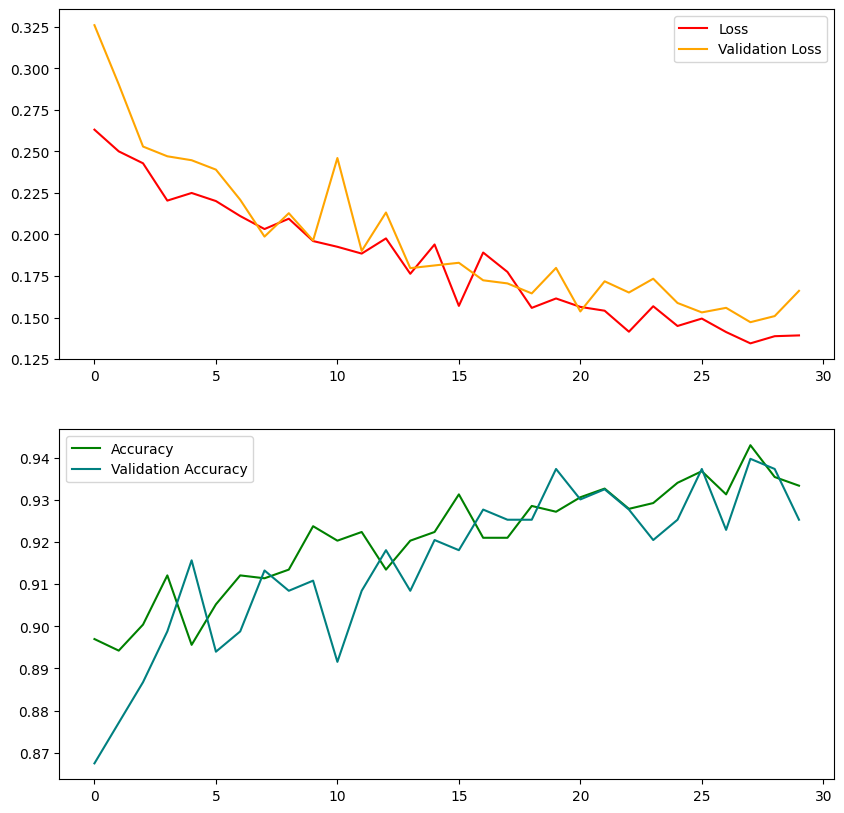

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

# Evaluating Model Performance

In [44]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(256, 256))

Found 210 files belonging to 2 classes.


In [45]:
test_data = test_dataset.map(lambda x, y: (x/255, y))

In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

In [47]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    spe.update_state(y, y_pred)

1/1 [==============================] - 0s 31ms/step


In [48]:
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', acc.result().numpy())
print('Precision\t:', precision)
print('Recall\t\t:', recall)
print('Specificity\t:', spe.result().numpy())
print('F1\t\t:', f1)

Accuracy	: 0.9380952
Precision	: 0.9059829
Recall		: 0.9814815
Specificity	: 1.0
F1		: 0.9422222255906718


# ----------------------------------

# Data Augmentation

In [49]:
from keras.preprocessing.image import ImageDataGenerator

In [51]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             brightness_range=(0.1, 1.5),
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')
    
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=16, 
                                                   target_size=(256,256),
                                                   class_mode='binary')

Found 1456 images belonging to 2 classes.


In [52]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size=16,
                                                target_size=(256, 256),
                                                class_mode='binary')

Found 415 images belonging to 2 classes.


In [53]:
model_fit = model.fit(train_generator, 
                      epochs=30, 
                      shuffle=True, 
                      validation_data=val_generator, 
                      callbacks=[tfb_callback])

Epoch 1/30
91/91 [==============================] - 12s 117ms/step - loss: 0.2950 - accuracy: 0.8791 - precision: 0.8689 - recall: 0.9013 - specificity_at_sensitivity: 0.9873 - val_loss: 0.1737 - val_accuracy: 0.9084 - val_precision: 0.9000 - val_recall: 0.9252 - val_specificity_at_sensitivity: 1.0000
Epoch 2/30
91/91 [==============================] - 10s 107ms/step - loss: 0.2425 - accuracy: 0.9011 - precision: 0.8826 - recall: 0.9320 - specificity_at_sensitivity: 0.9915 - val_loss: 0.1711 - val_accuracy: 0.9277 - val_precision: 0.9035 - val_recall: 0.9626 - val_specificity_at_sensitivity: 1.0000
Epoch 3/30
91/91 [==============================] - 10s 107ms/step - loss: 0.2014 - accuracy: 0.9176 - precision: 0.9028 - recall: 0.9413 - specificity_at_sensitivity: 0.9986 - val_loss: 0.1569 - val_accuracy: 0.9349 - val_precision: 0.9390 - val_recall: 0.9346 - val_specificity_at_sensitivity: 1.0000
Epoch 4/30
91/91 [==============================] - 10s 107ms/step - loss: 0.2266 - accurac

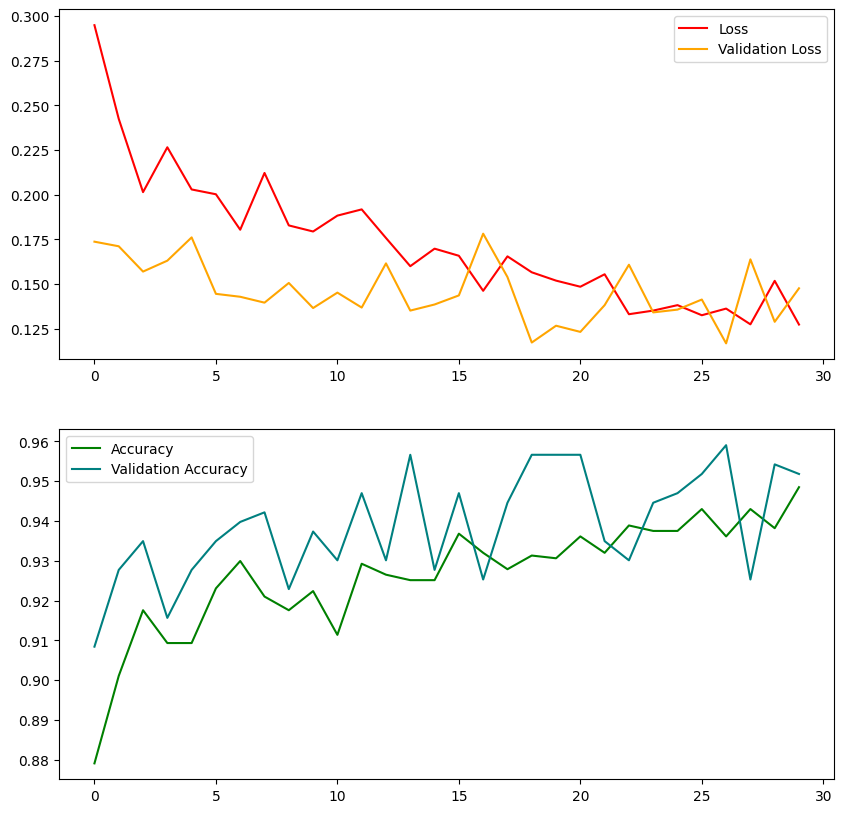

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

In [56]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                batch_size=16,
                                                target_size=(256, 256),
                                                class_mode='binary')

Found 210 images belonging to 2 classes.


In [57]:
evaluation = model.evaluate(test_generator, verbose=1)

accuracy = evaluation[1]  # 'accuracy'
precision = evaluation[2]  # Precision
recall = evaluation[3]     # Recall
specificity = evaluation[4]  # SpecificityAtSensitivity(0.5)

f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {round(accuracy, 5)}')
print(f'Precision: {round(precision, 5)}')
print(f'Recall: {round(recall, 5)}')
print(f'Specificity (at sensitivity 0.5): {round(specificity, 5)}')
print(f'F1: {round(f1, 5)}')

14/14 [==============================] - 1s 36ms/step - loss: 0.0801 - accuracy: 0.9810 - precision: 0.9643 - recall: 1.0000 - specificity_at_sensitivity: 1.0000
Accuracy: 0.98095
Precision: 0.96429
Recall: 1.0
Specificity (at sensitivity 0.5): 1.0
F1: 0.98182
